# Ravinders' Lesson

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import logistic_regression_util 
        # made by zach and v. useful for making some graphs

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Logistic Regression
- Fundamentals: 
    - https://docs.google.com/presentation/d/1AzgB6opDhEuAdBHZS8GRbBV6BtQCqb9JSAElM4-H6nk/edit?usp=sharing
    
- logistic regression in sklearn

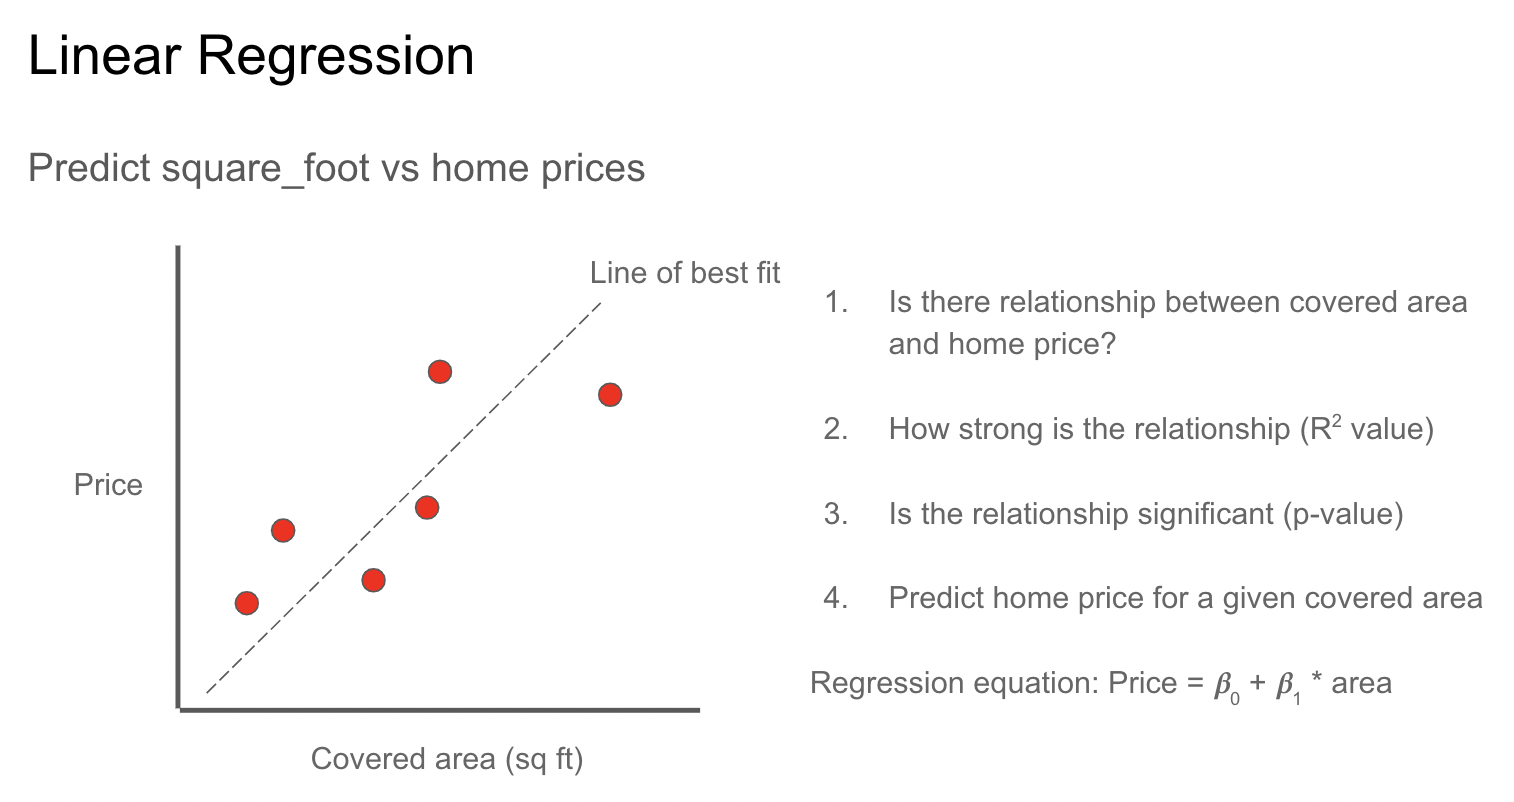

- how far is the line from the points?
- is there a relationship between my dependent variable and independent variable
    - how strong is the relationship
    - is it a significant relationship
    
- What is Beta 1?
    - is area changes by 1 unit how much will the pricce change
        - ex area goes up by 1 and price goes up by 500
            - for Beta 1 would be 500

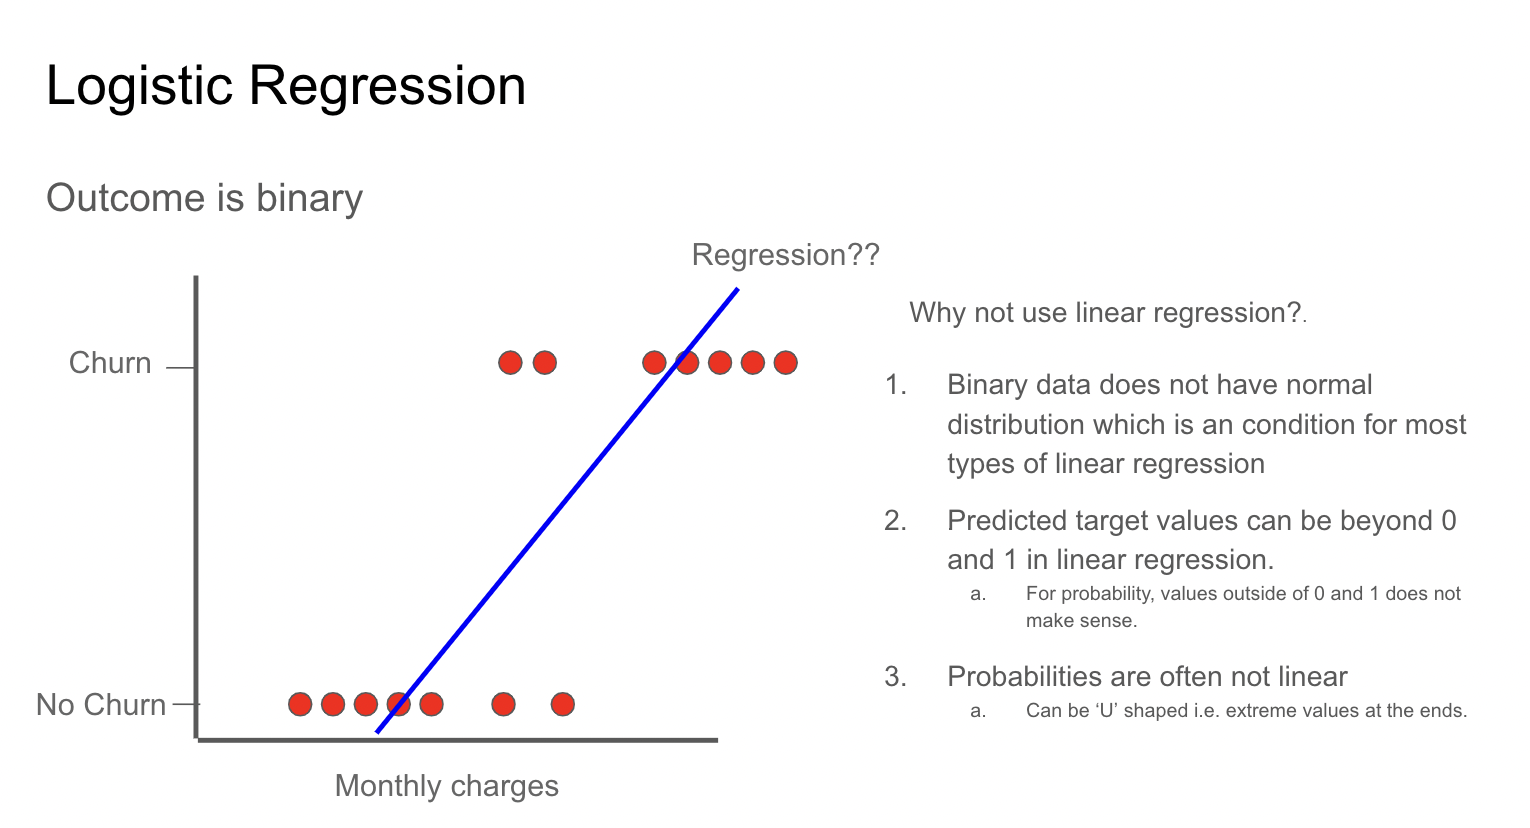

- Target variable is either 0 (no churn) or 1 (churn)
- the challenge now is how do we fid out the outcome into a binary instead of a continuous number
    - 1 of the conditions is that data is normally distributed
- our outcome here is not distributed it is binary
    - we should not do regression
- anything above 1 or below 0 dont make sense


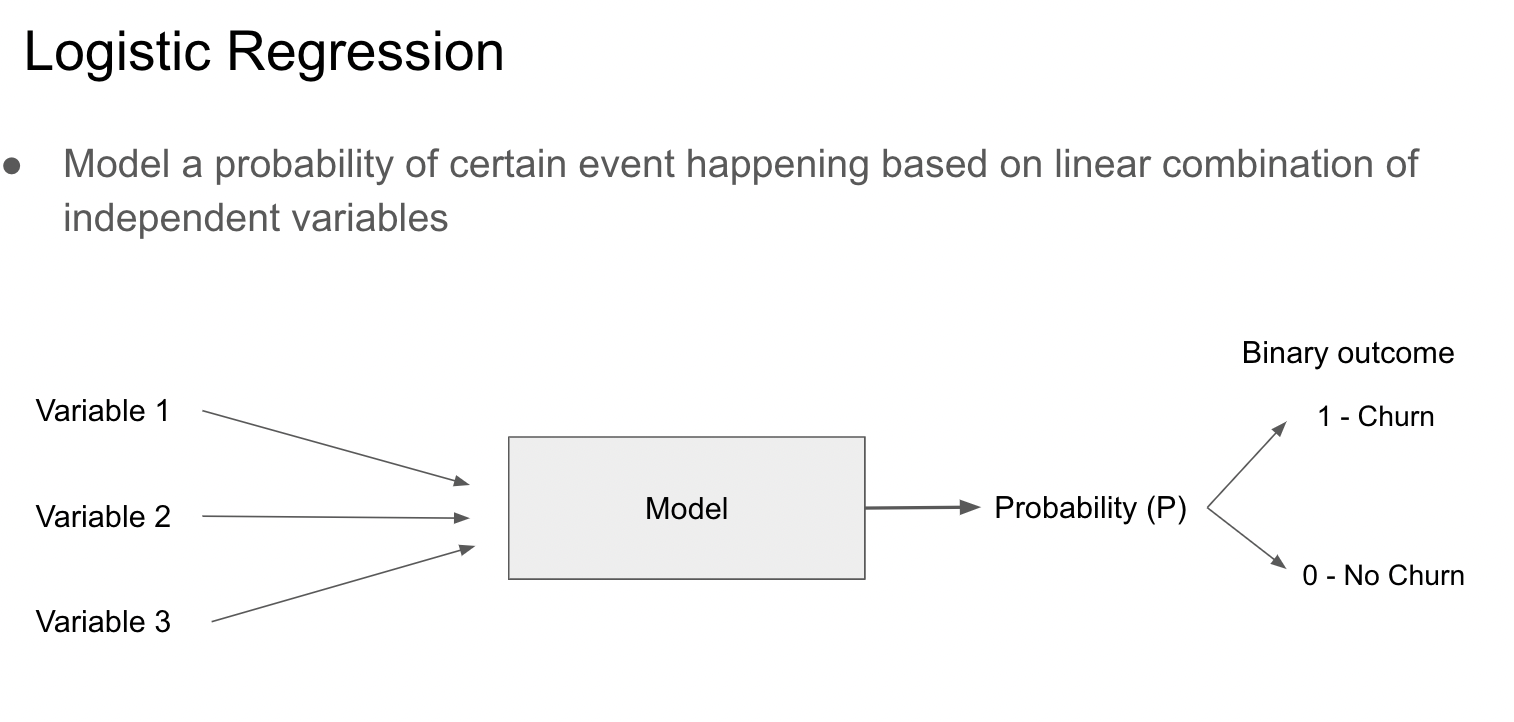

- How do we have our variables that are continouse
    - how to we map that to a binary?
- feed variables into our model
    - what is the probability
        - use that probablitly to snap into the binary outcomes
            - if prob of churn is above .5 it is 1
            - if prob of churn is below .5 it is 0

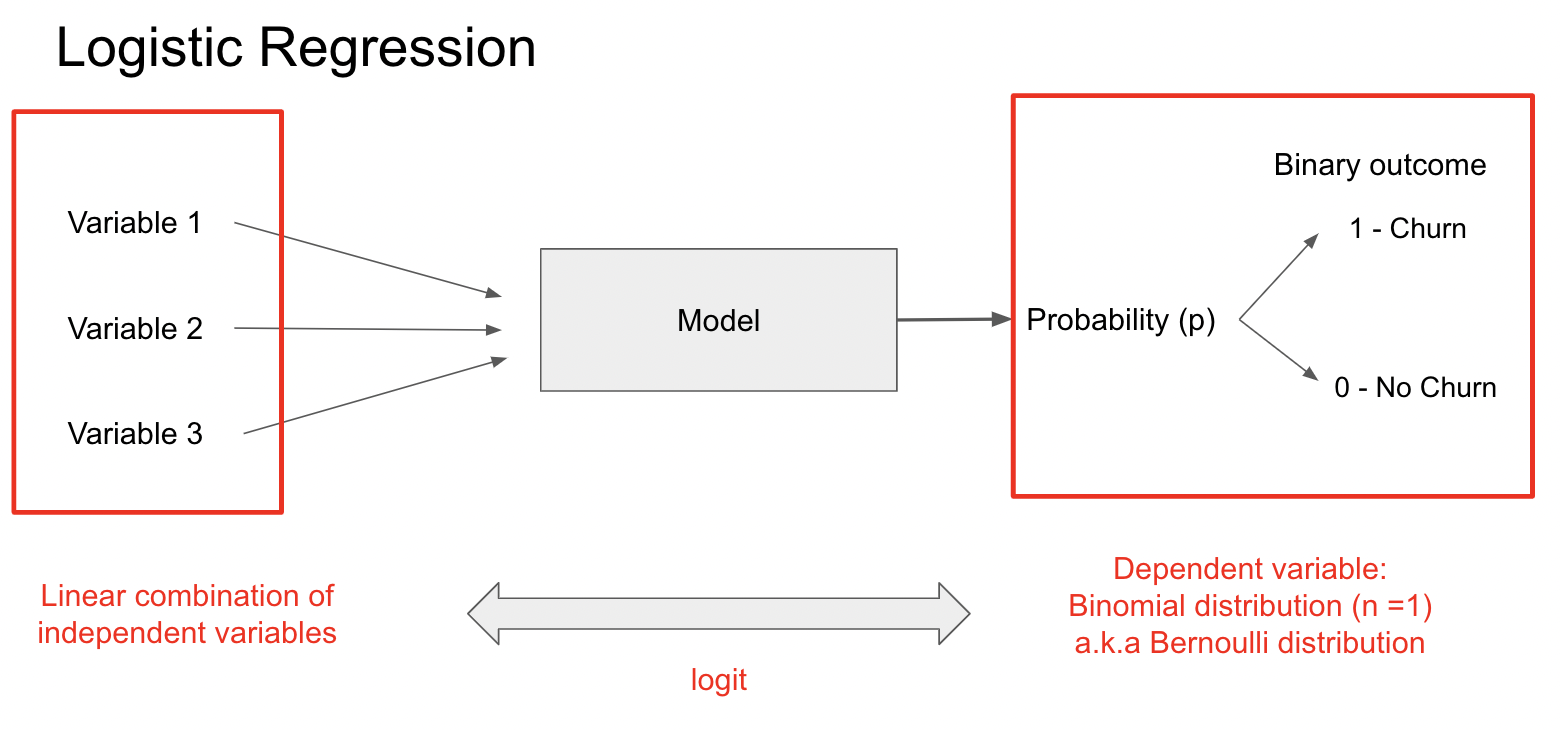

- How do you link:
    - linear combo of independent variables
    - binaolial distribution n=1 (bernoulli distribution
        - by using logit

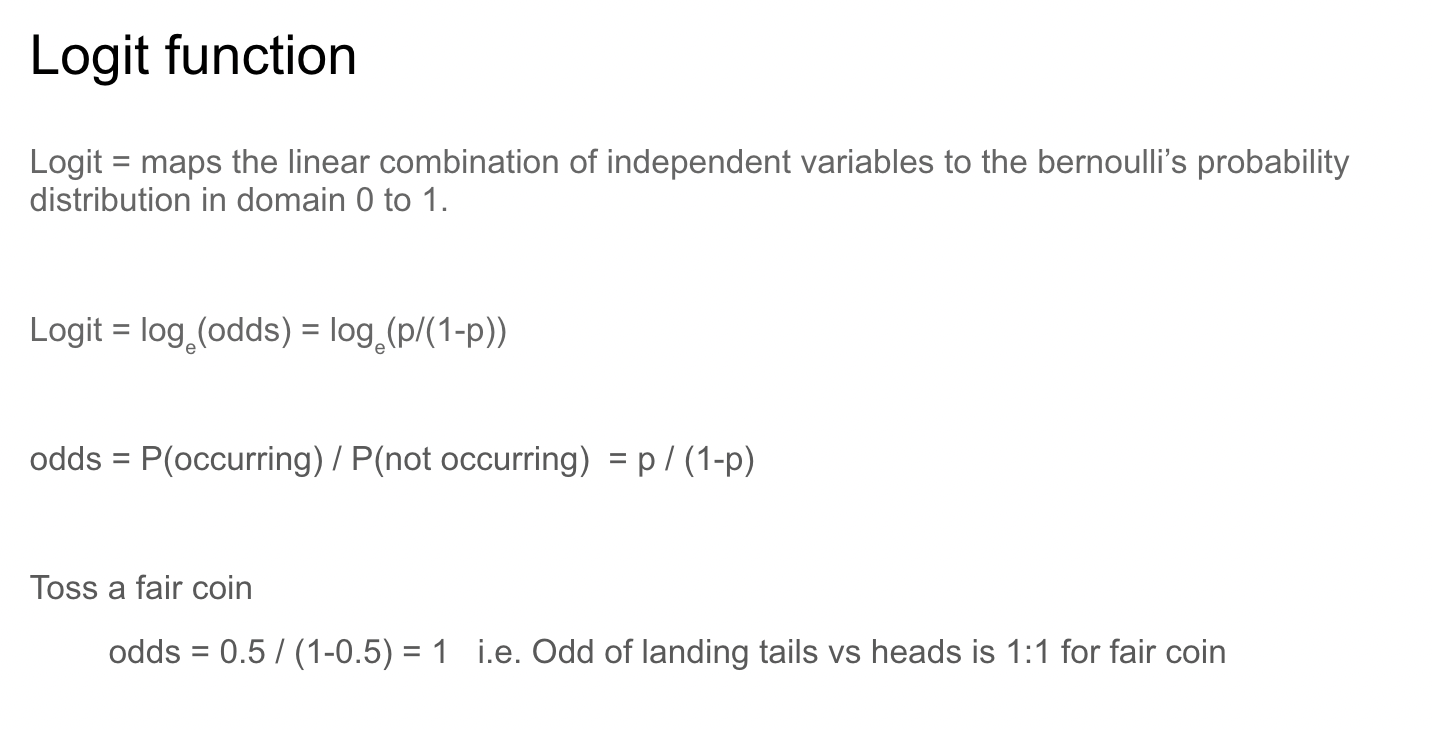

- What is this logit thing?
    - natural log of odds
        - odds
            - prob of somthing happening divide by prob of something not happening
                - p/(1-p)
            - toss a fair coin:
                - odds = 0.5/(1-0.5) = 1
                    - odd of landing tails vs. heads is 1:1 for a fair coin.

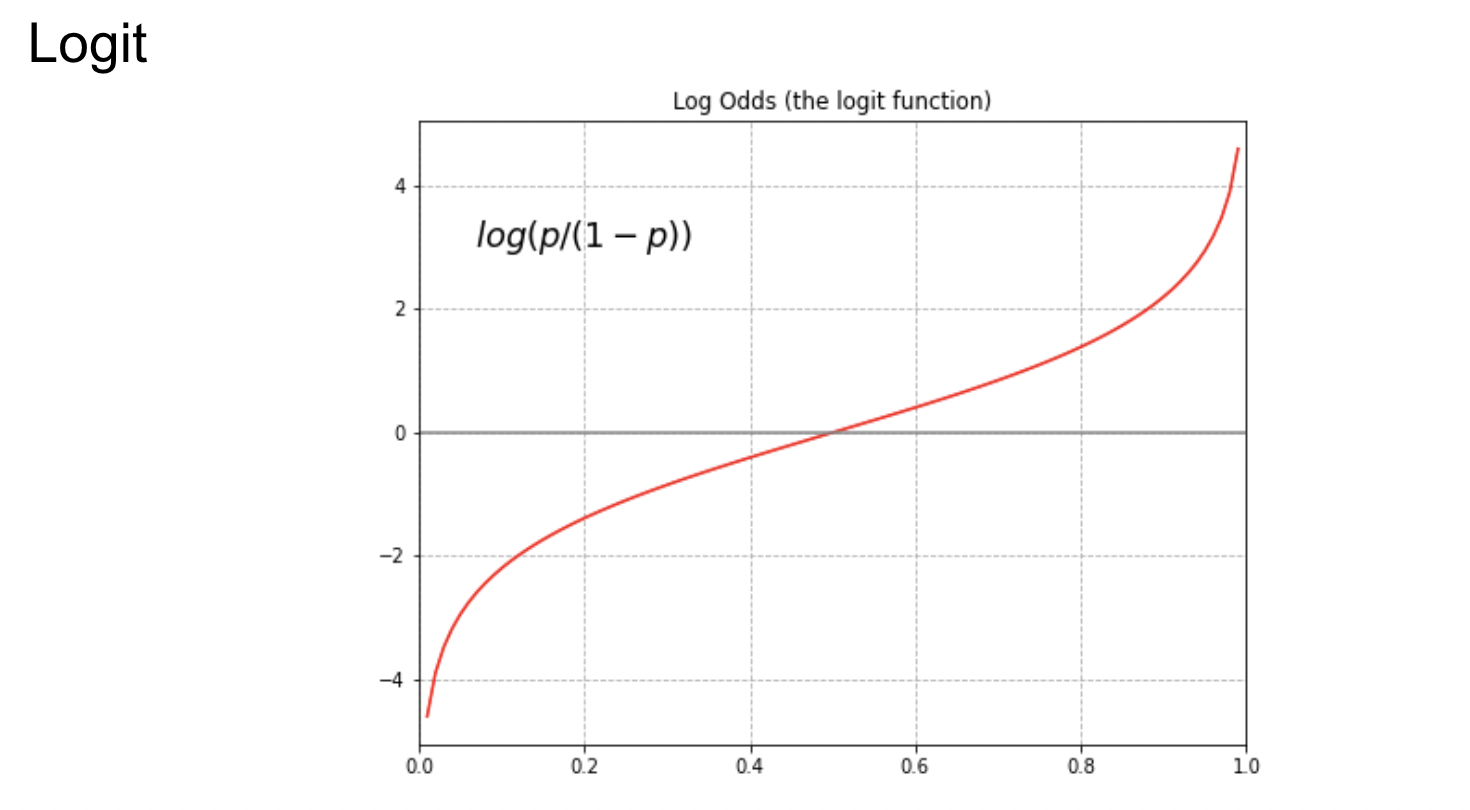

- Plot the logit funtion by waiving the p
    - use matplot lib
    - x axis is prob
    - y is logic value
        - What if value of p is .5
            - then odds is 1
                - what is log of 1
                    - 0
                        - that is what you see aboze
        - what if p is 0
            - then it is undefined
        - what is p is 1
            - then it is undefined

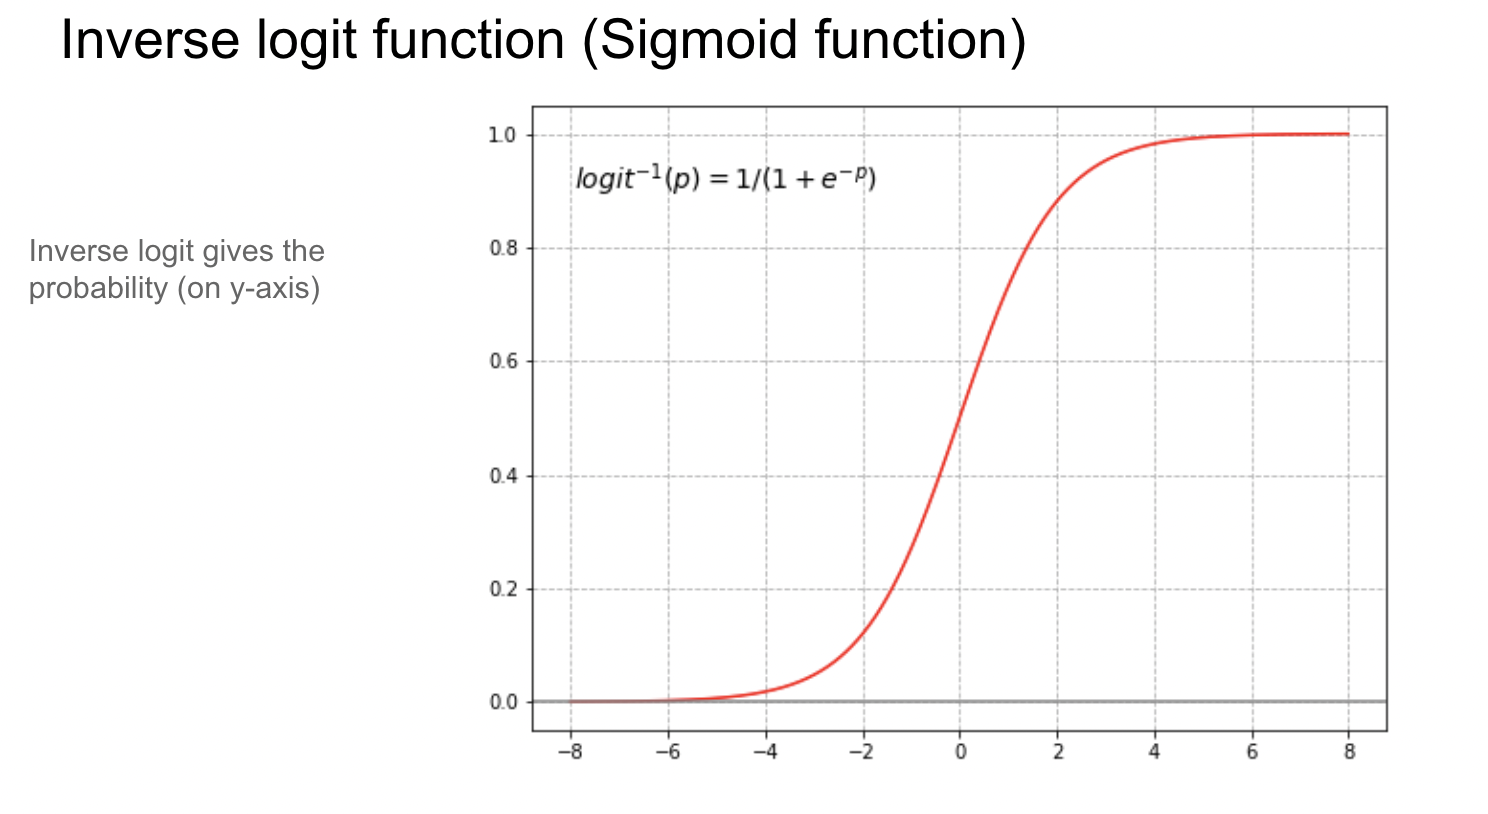

- prob on y axis
- logic value is on x axis

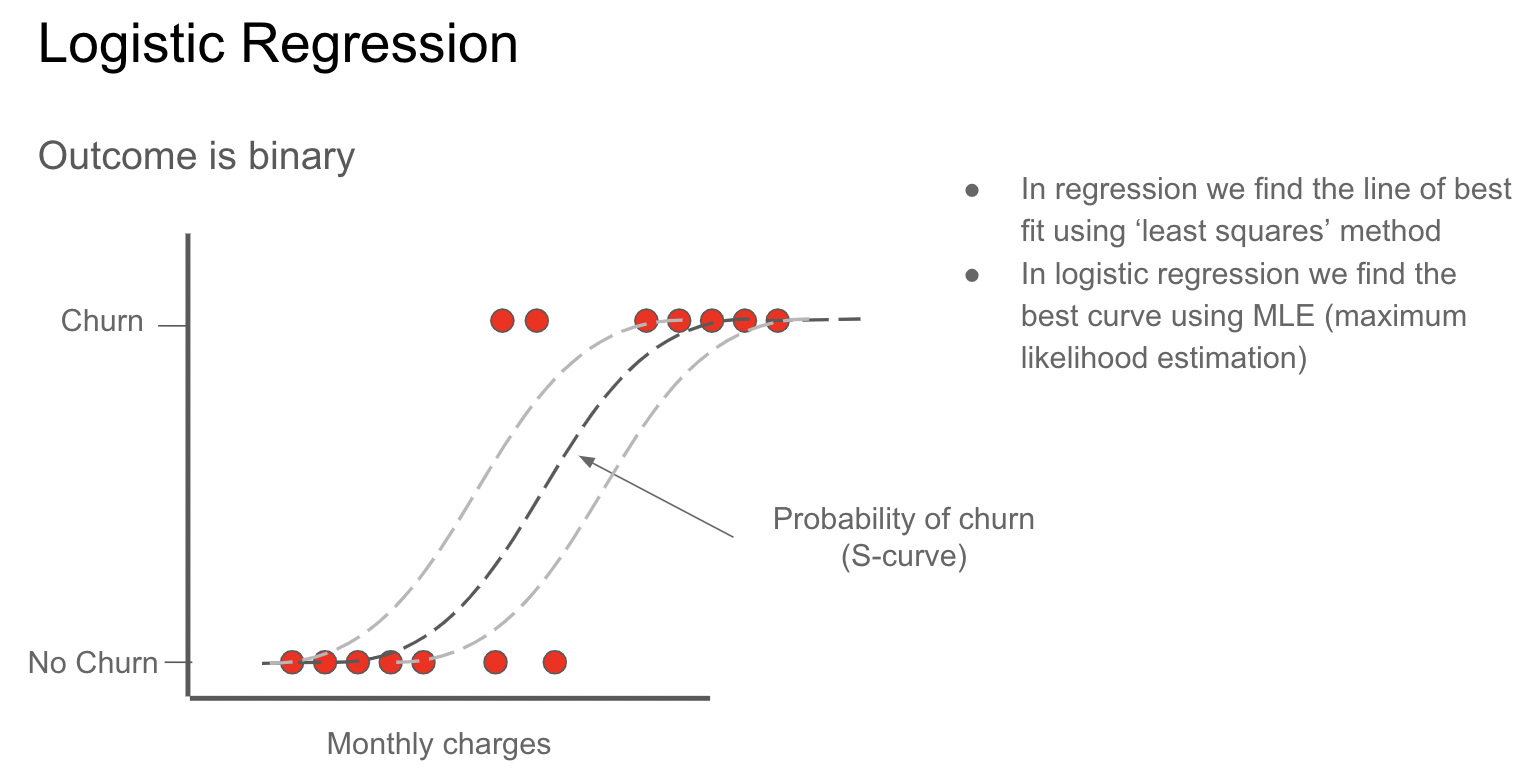

- we can curve the function 
    - gives us prob of churn
        - find optimun value of this curve toi find best estimate of churn and no churn
            - there are a few different ways to do this
                - Least squares
                - Maximum likelihood estimation
                    - if monthly charges has sum value we look up and see what the probability is for that monthly rate.

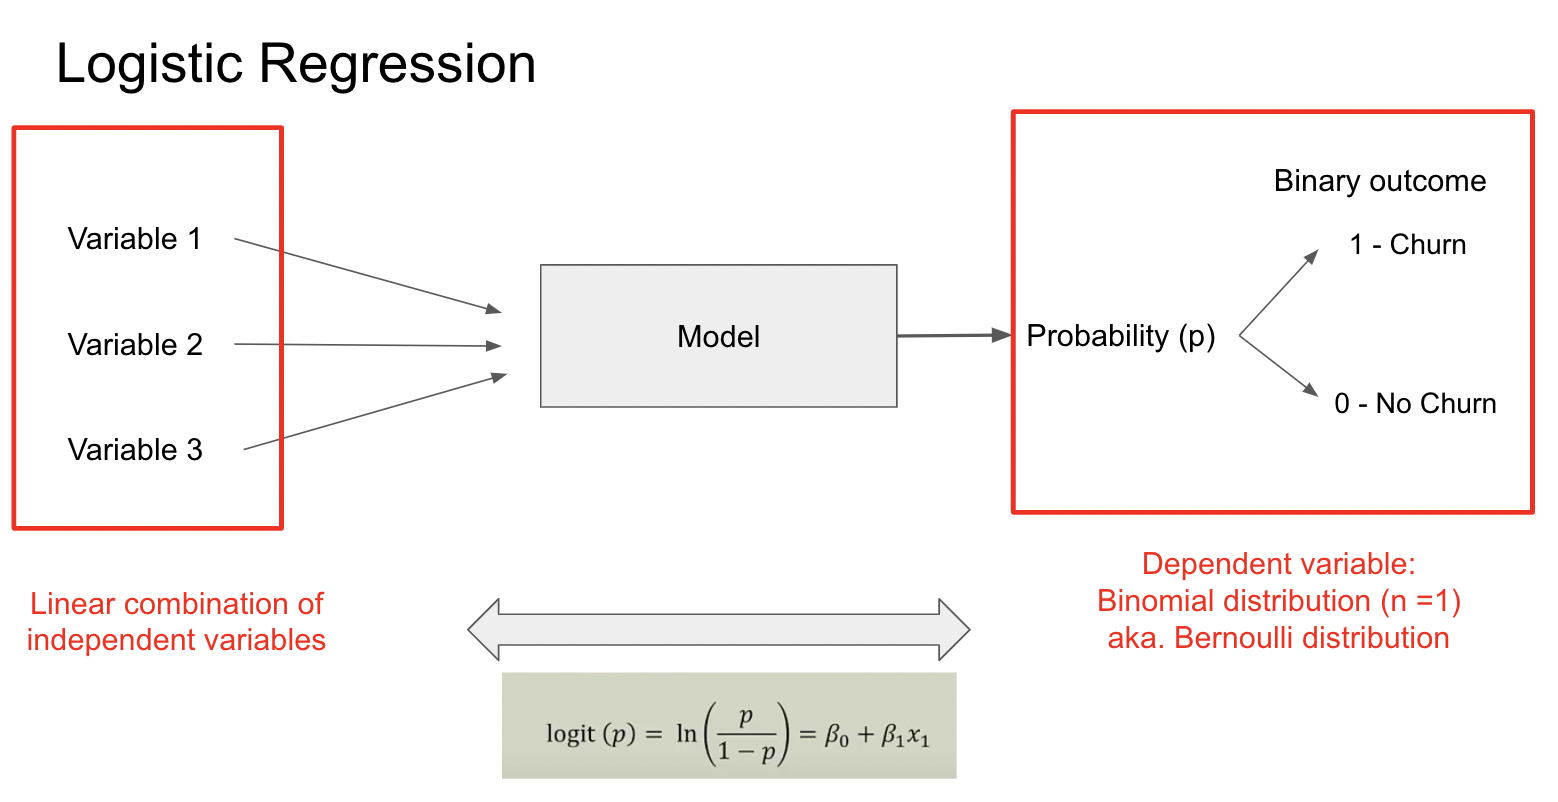

**Logistic is a classification algorithm and regression is a linear algorithm**

IMPORTANT - FIND A WAY TO EXPLAIN THE DIFFERENCE BETWEEN THESE 2 ALGORITHMS THEY WILL BE INTERVIEW QUESTIONS

#### Pros
- fast to train, very fast to predict
- probabilities as output
- more interpretable than some other classification models
#### Cons
- less interpretable than some other classification models
- assume the X predictors are independent
- multi-class classification is more complicated (one-vs-rest)
- Great baseline

In [2]:
from pydataset import data

df = data('iris')
df.head()

Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
1           5.1          3.5           1.4          0.2  setosa
2           4.9          3.0           1.4          0.2  setosa
3           4.7          3.2           1.3          0.2  setosa
4           4.6          3.1           1.5          0.2  setosa
5           5.0          3.6           1.4          0.2  setosa

In [3]:
# columns name change
df.columns = [col.lower().replace('.', '_') for col in df]
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [4]:
# we will have 2 different target variables 
# dummies = pd.get_dummies(df['species'], drop_first=True)

dummies = pd.get_dummies(df['species'], drop_first = True)
dummies.head()

versicolor  virginica
1           0          0
2           0          0
3           0          0
4           0          0
5           0          0

In [5]:
# concat dummies and original df. Drop 'species column'
df = pd.concat([df, dummies], axis =1).drop(columns = ['species'])
df.head()

sepal_length  sepal_width  petal_length  petal_width  versicolor  virginica
1           5.1          3.5           1.4          0.2           0          0
2           4.9          3.0           1.4          0.2           0          0
3           4.7          3.2           1.3          0.2           0          0
4           4.6          3.1           1.5          0.2           0          0
5           5.0          3.6           1.4          0.2           0          0

#### Problem statement: predict if species is vversicolor or not

In [7]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [8]:
train, validate, test = train_validate_test_split(df,
                                                  target = 'versicolor',
                                                  seed=123)

In [9]:
train.head()

sepal_length  sepal_width  petal_length  petal_width  versicolor  \
97            5.7          2.9           4.2          1.3           1   
125           6.7          3.3           5.7          2.1           0   
87            6.7          3.1           4.7          1.5           1   
13            4.8          3.0           1.4          0.1           0   
122           5.6          2.8           4.9          2.0           0   

     virginica  
97           0  
125          1  
87           0  
13           0  
122          1

In [10]:
train.versicolor.value_counts()
# 0 = not versicolor
# 1 = versicolor

0    56
1    28
Name: versicolor, dtype: int64

In [11]:
# Make new dataframes
X_train = train.drop(columns=['versicolor']) # dropping cause it is our target and we dont want it in our model
y_train = train.versicolor

X_validate = validate.drop(columns=['versicolor'])
y_validate = validate.versicolor

X_test = test.drop(columns=['versicolor'])
y_test = test.versicolor

In [12]:
X_train.head()

sepal_length  sepal_width  petal_length  petal_width  virginica
97            5.7          2.9           4.2          1.3          0
125           6.7          3.3           5.7          2.1          1
87            6.7          3.1           4.7          1.5          0
13            4.8          3.0           1.4          0.1          0
122           5.6          2.8           4.9          2.0          1

In [13]:
X_train.shape, y_train.shape
# make sure they have the same shape
    # 84 and 84 we are good

((84, 5), (84,))

## Model 1

- **C controls the Regularizations:**
    - tells it to not make  too complex of a model
    - keep model simple
    - avoid overfitting
    - L1
        - Lasoo regression
    - L2
        - Ridge

In [14]:
# Define the logistic regression model
logit = LogisticRegression(C=1, class_weight={0:1, 1:99},
                           random_state=123)
# C's default is 1

In [15]:
# fit the model on train data
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

In [16]:
# now use the model to make predictions
y_pred = logit.predict(X_train)

In [17]:
#take a look at predictions
y_pred

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0], dtype=uint8)

In [24]:
# View raw probabilities (output from the model)

y_pred_proba =logit.predict_proba(X_train)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['non-versicolor', 'versicolor'])
y_pred_proba.head()

non-versicolor  versicolor
0        0.006238    0.993762
1        0.820550    0.179450
2        0.006395    0.993605
3        0.609259    0.390741
4        0.757112    0.242888

In [25]:
# classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        56
           1       0.88      1.00      0.93        28

    accuracy                           0.95        84
   macro avg       0.94      0.96      0.95        84
weighted avg       0.96      0.95      0.95        84



## Model 2

In [27]:
# from sklearn.linear_model import LogisticRegression model(2)
# Change hyperparameter C = 0.1
# C controls the Regularizations: 
        # tells it to not make  too complex of a model
        # keep model simple
        # avoid overfitting
        # L1
            # Lasoo regression
        # L2
            # Ridge
logit2 = LogisticRegression(C=0.1, class_weight={0:1, 1:99}, random_state=123)

In [28]:
# fit the model
logit2.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 99}, random_state=123)

In [29]:
# make prediction
y_pred2 = logit2.predict(X_train)

In [30]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        56
           1       0.88      1.00      0.93        28

    accuracy                           0.95        84
   macro avg       0.94      0.96      0.95        84
weighted avg       0.96      0.95      0.95        84



## Evaluate Model 1 and 2 performance on 'Validate'

In [31]:
# Make prediction for validate dataset

y_pred_validate = logit.predict(X_validate)
y_pred_validate2 = logit2.predict(X_validate)

In [34]:
print("Model 1: solver = lbfgs, c = 1")

print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

print(confusion_matrix(y_validate, y_pred_validate))

print(classification_report(y_validate, y_pred_validate))
print("--------------------------------------------------")
print("Model 2: solver = lbfgs, c = .1")

print('Accuracy: {:.2f}'.format(logit2.score(X_validate, y_validate)))

print(confusion_matrix(y_validate, y_pred_validate2))

print(classification_report(y_validate, y_pred_validate2))

Model 1: solver = lbfgs, c = 1
Accuracy: 0.94
[[22  2]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.86      1.00      0.92        12

    accuracy                           0.94        36
   macro avg       0.93      0.96      0.94        36
weighted avg       0.95      0.94      0.95        36

--------------------------------------------------
Model 2: solver = lbfgs, c = .1
Accuracy: 0.33
[[ 0 24]
 [ 0 12]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.33      1.00      0.50        12

    accuracy                           0.33        36
   macro avg       0.17      0.50      0.25        36
weighted avg       0.11      0.33      0.17        36



## Select Model for evaluation on 'test'
- Model 1 does not seem overfitted/underfitted.
- Select Model 1 for evaluation on 'test' dataset

In [35]:
# Make prediction on X_test using model 1
y_pred_test =logit.predict(X_test)

In [37]:
# print classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.71      1.00      0.83        10

    accuracy                           0.87        30
   macro avg       0.86      0.90      0.86        30
weighted avg       0.90      0.87      0.87        30



## Interpreting model coefficients

In [38]:
# look at model 1 coefficents and intercept
 
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.42681384 -2.98522269  1.96274678  0.08740801 -7.98399654]]
Intercept: 
 [7.80358914]


In [39]:
# look at model 1 coefficents only
logit.coef_[0]

array([-0.42681384, -2.98522269,  1.96274678,  0.08740801, -7.98399654])

In [44]:
# look at model 2 coefficents only
logit2.coef_[0]

array([-0.19445819, -1.61580992,  1.05115027, -0.16751972, -2.52871891])

#### Logistic Regression basics:
log(odds) = log(p/(1-p)) = $intercept$ + ($\beta_1$ variable1) + ($\beta_2$ variable2) + ($\beta_3$ * variable3)

In [51]:
# Make a dataframe of coefficients and feature names

log_coeffs= pd.DataFrame(logit.coef_[0], index = X_train.columns, 
                         columns = ['coeffs']).sort_values(by = 'coeffs', 
                         ascending = True)
log_coeffs

coeffs
virginica    -7.983997
sepal_width  -2.985223
sepal_length -0.426814
petal_width   0.087408
petal_length  1.962747

In [52]:
# convert from log odds to odds (exponentiate)
odds = np.exp(log_coeffs)
odds

coeffs
virginica     0.000341
sepal_width   0.050528
sepal_length  0.652585
petal_width   1.091342
petal_length  7.118854

**For every one unit in petal_length, the odds that oservation is versicolor('1') is 7.1 times higher than the odds that observation is not versicolor('0'), assuming all other things remain the same.**

### Choosing different probability threshold:
Default threshold value is 0.5

We choose a **threshold t** such that if $P(y = 1) &gt; t$, we predict 1, else we predict 0.

In [53]:
t = 0.3
    # above .3 = 1
    # below .3 = 0
y_pred1 = (y_pred_proba > t).astype(int)
y_pred1.head()

non-versicolor  versicolor
0               0           1
1               1           0
2               0           1
3               1           1
4               1           0

In [58]:
# classification report for threshold = t
print(classification_report(y_train, y_pred1.versicolor))

              precision    recall  f1-score   support

           0       1.00      0.66      0.80        56
           1       0.60      1.00      0.75        28

    accuracy                           0.77        84
   macro avg       0.80      0.83      0.77        84
weighted avg       0.87      0.77      0.78        84



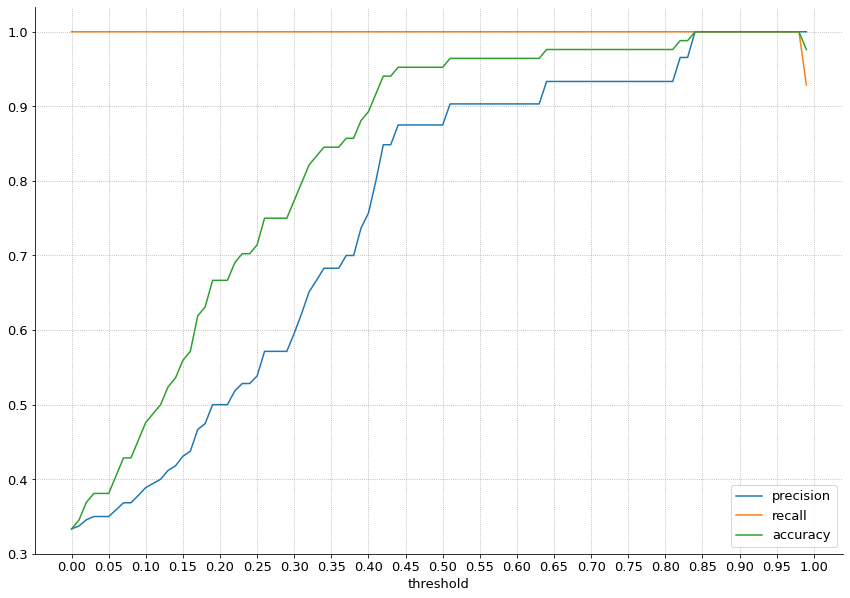

In [59]:
# plot metrics vs thresholds
logistic_regression_util.plot_metrics_by_thresholds(y_train, y_pred_proba.versicolor)

## Logistic Regression
### What is Logistic Regression?
- Technically a regression algorithm (goal is to find the values for the coefficients that weight each input variable)
- Used for predicting discrete outcomes (binomial and multinomial)
- Because the prediction for the output is transformed using the logistic function, a non-linear function, it is a classification algorithm.
- The output is a value between 0 and 1 that represents the probability of one class over the other.

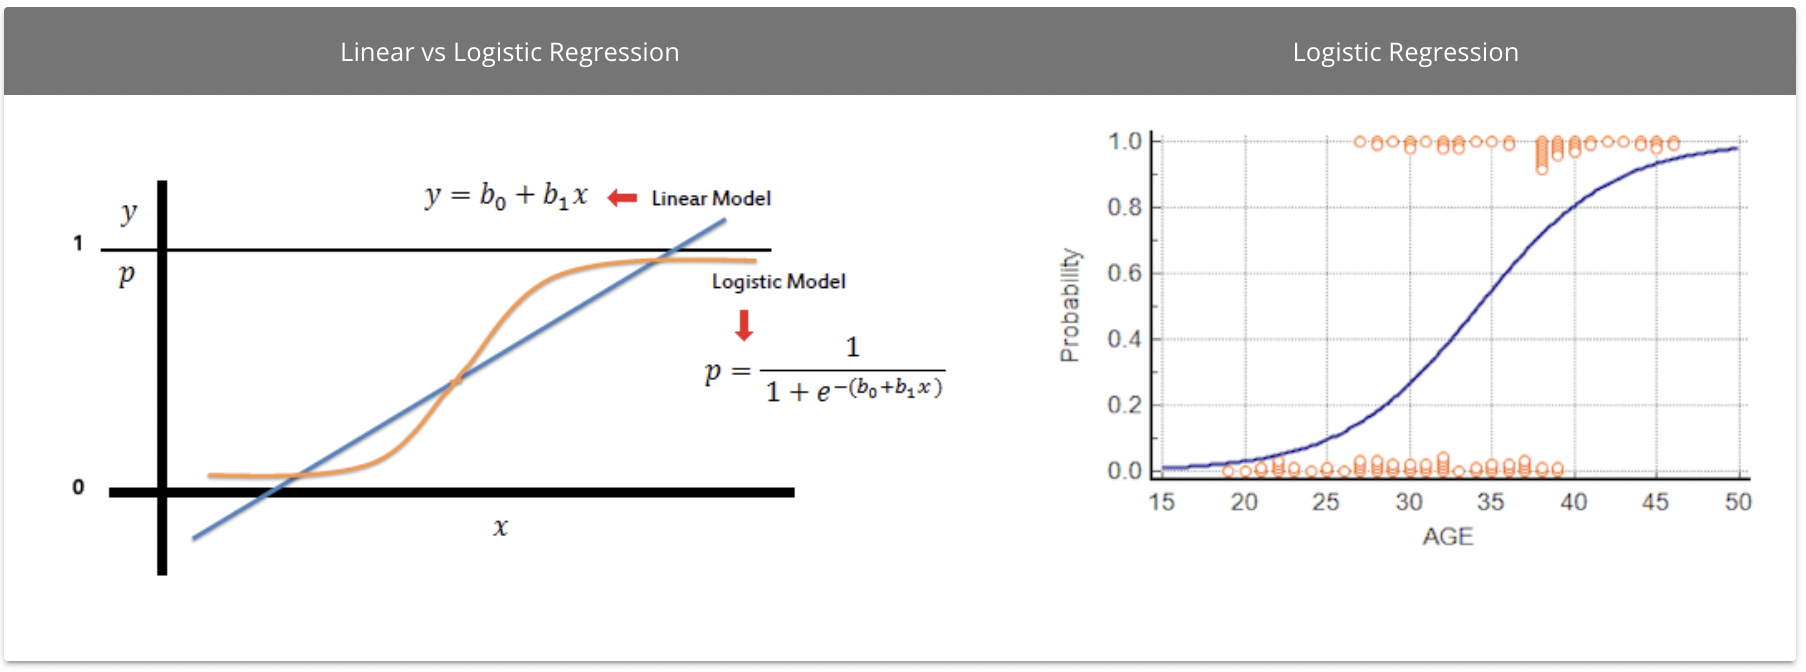

### Pros
1. High interpretabability. It's explainable to others, i.e. it's useful for understanding the influence of several independent variables on a single outcome variable.
2. We can choose to ‘snap’ predictions to 0 and 1 via a rule (such as if < .5, 0 else 1) OR we can choose to use the output as is, which is a probability of being class 1.
3. It’s a fast model and is a good place to start with a benchmark for comparing with other classification algorithms.
4. Very efficient and does not require many computational resources. Runs fast.
5. Outputs clear predicted probabilities.

### Cons
1. Assumes all predictors are independent of each other.
2. Missing values must be dealt with prior to fitting the model.
    - you wither need to compute them or throw them out
3. We can’t solve non-linear problems with logistic regression since it’s decision surface is linear.
    - if is not linear then you cant use this
4. Not always as accurate as other classification algorithms.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pydataset import data

df = data('iris')

df.columns = [col.lower().replace('.', '_') for col in df]

# we will have 2 different target variables 
dummies = pd.get_dummies(df['species'], drop_first=True)

df = pd.concat([df, dummies], axis=1).drop(columns=['species'])
df.head()

sepal_length  sepal_width  petal_length  petal_width  versicolor  virginica
1           5.1          3.5           1.4          0.2           0          0
2           4.9          3.0           1.4          0.2           0          0
3           4.7          3.2           1.3          0.2           0          0
4           4.6          3.1           1.5          0.2           0          0
5           5.0          3.6           1.4          0.2           0          0

## Train Validate Test
Now we'll do our train/validate/test split:
- We will walk through the lesson aiming to predict versicolor.
- We'll do exploration and train our model on the train data
- We tune our model on validate, since it will be out-of-sample until we use it.
- And keep the test nice and safe and separate, for our final out-of-sample dataset, to see how well our tuned model performs on new data.

In [2]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [3]:
train, validate, test = train_validate_test_split(df, target='versicolor', seed=123)

X_train = train.drop(columns=['versicolor'])
y_train = train.versicolor

X_validate = validate.drop(columns=['versicolor'])
y_validate = validate.versicolor

X_test = test.drop(columns=['versicolor'])
y_test = test.versicolor

We'll use the LogisticRegression class from the sklearn.linear_model module to implement our model.

- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### Arguments

- **penalty**: 
    - str, 'l1' or 'l2', default: 'l2', Used to specify the norm used in the penalization. The 'newton-cg', 'sag' and 'lbfgs' solvers support only l2 penalties. We will discuss l1 & l2 penalties & regularization
- **C**: 
    - float, default: 1.0, Inverse of regularization strength; must be a positive float.
- **class_weight**: 
    - dict or 'balanced', default: None, Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.
- **random_state**: 
    - set the seed for reproducibility.
- **intercept_scaling**: 
    - float, default 1. Useful only when the solver 'liblinear' is used and self.fit_intercept is set to True and you have not already scaled your data.
- **solver**: 
    - {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default: 'liblinear', but will change to 'lbfgs' in v 0.22. The solver is the algorithm to use in the optimization problem. For small datasets, 'liblinear' is a good choice, whereas 'sag' and 'saga' are faster for large ones. For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs' handle multinomial loss; 'liblinear' is limited to one-versus-rest schemes. 'newton-cg', 'lbfgs' and 'sag' only handle L2 penalty, whereas 'liblinear' and 'saga' handle L1 penalty. If using sag and saga solvers, make sure the features are on a similar scale.
- **max_iter**: 
    - int, default: 100, Useful only for the newton-cg, sag and lbfgs solvers, Maximum number of iterations taken for the solvers to converge.
- **multi_class**: 
    - I recommend using other algorithms for multiclass or one-vs-rest if you want to use logistic regression. options: {'ovr', 'multinomial', 'auto'}, default: 'ovr' (one-versus-rest). If the option chosen is 'ovr', then a binary problem is fit for each label. For 'multinomial' the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. 'multinomial' is unavailable when solver='liblinear'. 'auto' selects 'ovr' if the data is binary, or if solver='liblinear', and otherwise selects 'multinomial'.

## Model #1
Using the lbfgs solver.

## Create, Fit, & Predict
### Create the logistic regression object

In [4]:
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

### Fit the model to the training data

In [5]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

### Print the coefficients and intercept of the model

In [6]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.42681384 -2.98522269  1.96274678  0.08740801 -7.98399654]]
Intercept: 
 [7.80358914]


### Estimate whether or not a passenger would survive, using the training data

In [7]:
y_pred = logit.predict(X_train)

### Estimate the probability of a passenger surviving, using the training data

In [8]:
y_pred_proba = logit.predict_proba(X_train)

## Evaluate Model on Train
### Compute the accuracy

In [9]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.95


### Create a confusion matrix

In [10]:
print(confusion_matrix(y_train, y_pred))

[[52  4]
 [ 0 28]]


### Compute Precision, Recall, F1-score, and Support

In [11]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        56
           1       0.88      1.00      0.93        28

    accuracy                           0.95        84
   macro avg       0.94      0.96      0.95        84
weighted avg       0.96      0.95      0.95        84



## Model #2
### We can create new models by changing features we feed the algorithm, hyperparameters, and/or the alogrithm itself. For this second model, we will adjust our hyperparameter, C.

In [15]:
logit2 = LogisticRegression(C=.1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

In [16]:
logit2.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 99}, random_state=123)

In [17]:
print('Coefficient: \n', logit2.coef_)
print('Intercept: \n', logit2.intercept_)

Coefficient: 
 [[-0.19445819 -1.61580992  1.05115027 -0.16751972 -2.52871891]]
Intercept: 
 [5.55477327]


In [18]:
y_pred2 = logit2.predict(X_train)
y_pred_proba2 = logit2.predict_proba(X_train)

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit2.score(X_train, y_train)))

print(confusion_matrix(y_train, y_pred2))

print(classification_report(y_train, y_pred2))

Accuracy of Logistic Regression classifier on training set: 0.42
[[ 7 49]
 [ 0 28]]
              precision    recall  f1-score   support

           0       1.00      0.12      0.22        56
           1       0.36      1.00      0.53        28

    accuracy                           0.42        84
   macro avg       0.68      0.56      0.38        84
weighted avg       0.79      0.42      0.33        84



- **Precision**: 
    - TP/(TP+FP)
- **Recall**: 
    - TP/(TP+FN)
- **F1-Score**: 
    - A measure of accuracy. The harmonic mean of precision & recall. The harmonic mean is the reciprocal of the arithmetic mean of the reciprocals.
        - F1 ∈[0,1]
        - F1-score = harmonic mean = 2/((1/precision)+(1/recall)
- **Support**: 
    - number of occurrences of each class.

## Validate Models
Are either overfitting? Let's validate on unseen data, X_validate. This means we use logit & logit2 to predict on X_validate.

In [19]:
y_pred1 = logit.predict(X_validate)
y_pred2 = logit2.predict(X_validate)

print("Model 1: solver = lbfgs, c = 1")

print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

print(confusion_matrix(y_validate, y_pred1))

print(classification_report(y_validate, y_pred1))

print("Model 2: solver = lbfgs, c = .1")

print('Accuracy: {:.2f}'.format(logit2.score(X_validate, y_validate)))

print(confusion_matrix(y_validate, y_pred2))

print(classification_report(y_validate, y_pred2))

Model 1: solver = lbfgs, c = 1
Accuracy: 0.94
[[22  2]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.86      1.00      0.92        12

    accuracy                           0.94        36
   macro avg       0.93      0.96      0.94        36
weighted avg       0.95      0.94      0.95        36

Model 2: solver = lbfgs, c = .1
Accuracy: 0.33
[[ 0 24]
 [ 0 12]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.33      1.00      0.50        12

    accuracy                           0.33        36
   macro avg       0.17      0.50      0.25        36
weighted avg       0.11      0.33      0.17        36



## Test Model
### Compute the accuracy of the model when run on the test data

In [20]:
y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)

print("Model 1: solver = lbfgs, c = 1")

print('Accuracy: {:.2f}'.format(logit.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Model 1: solver = lbfgs, c = 1
Accuracy: 0.87
[[16  4]
 [ 0 10]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.71      1.00      0.83        10

    accuracy                           0.87        30
   macro avg       0.86      0.90      0.86        30
weighted avg       0.90      0.87      0.87        30



## Visualize Model

In [21]:
## verify
# y_pred_proba = [i[1] for i in y_pred_proba]

y_pred_proba = np.array([i[1] for i in y_pred_proba])

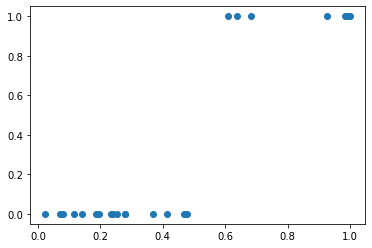

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred_proba, y_pred)

In [23]:
X_test

sepal_length  sepal_width  petal_length  petal_width  virginica
70            5.6          2.5           3.9          1.1          0
106           7.6          3.0           6.6          2.1          1
33            5.2          4.1           1.5          0.1          0
119           7.7          2.6           6.9          2.3          1
143           5.8          2.7           5.1          1.9          1
26            5.0          3.0           1.6          0.2          0
117           6.5          3.0           5.5          1.8          1
80            5.7          2.6           3.5          1.0          0
51            7.0          3.2           4.7          1.4          0
137           6.3          3.4           5.6          2.4          1
131           7.4          2.8           6.1          1.9          1
124           6.3          2.7           4.9          1.8          1
52            6.4          3.2           4.5          1.5          0
91            5.5          2.6           4.4          1.2          0
134           6.3          2.8           5.1          1.5          1
86            6.0          3.4           4.5          1.6          0
76            6.6          3.0           4.4          1.4          0
3             4.7          3.2           1.3          0.2          0
108           7.3          2.9           6.3          1.8          1
47            5.1          3.8           1.6          0.2          0
48            4.6          3.2           1.4          0.2          0
18            5.1          3.5           1.4          0.3          0
55            6.5          2.8           4.6          1.5          0
147           6.3          2.5           5.0          1.9          1
118           7.7          3.8           6.7          2.2          1
37            5.5          3.5           1.3          0.2          0
66            6.7          3.1           4.4          1.4          0
50            5.0          3.3           1.4          0.2          0
129           6.4          2.8           5.6          2.1          1
96            5.7          3.0           4.2          1.2          0

## Additional Example Logistic Regressions
Binary Logistic Regression predicting likelihood of bank customers to sign up for a new product.
    - https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

Multinomial Logistic Regression predicting species from the Iris Dataset
    - https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html